In [ ]:
import BALROG_pipeline as bp
import torch 
import numpy as np
import pandas as pd
import seaborn as sb
import torchvision
from rembg import new_session
import matplotlib.pyplot as plt
bg_session = new_session()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
# Load model
model = torch.load("models/final_models/model_2_deft-bird-19.pt", map_location=torch.device('cpu'))

# Read corresponding test data
df = pd.read_pickle("/Users/kristophernolte/Documents/phd_application_v3/results/final_models/test_df_2.pkl")
df["Image ID"] = [x.split("/")[-1].split(".")[0].split("_")[-1] for x in df["PATH"].values]
df_ref = pd.read_pickle("database_reference_MLREADY.pkl")

# Merge dataframes to get metadata for the test set
df_merged = pd.merge(df, df_ref, on="Image ID", how="inner")

/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_2913/3399692852.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("models/final_models/model_

In [ ]:
# Select 12 images from each class
df_sample = df_merged.loc[df_merged["Project"] == "CNN-Study"].groupby("LABEL").apply(lambda x: x.sample(12, replace=True)).reset_index(drop=True)

grad_dict, guided_dict, image_dict = {}, {}, {}
for label in df_sample["LABEL"].unique():
    grad_ls, guided_ls, image_ls = [], [], []
    path_ls = df_sample.loc[df_sample["LABEL"] == label, "PATH"].values
    for path in path_ls:
        # Load and preprocess image with pipeline
        image = bp.image_preprocessing_pipeline("/Users/kristophernolte/Documents/MosquitoWingDataset/" + path, bg_session)
        image = torchvision.transforms.functional.resize(image, (192, 384))
        species_list = np.asarray(bp.get_species_list())
        class_idx = np.argmax(label == species_list)

        # Create guided backpropagation and grad-CAM
        grayscale_cam, guided_grads = bp.create_guided_cam(model, image.unsqueeze(0), class_idx)

        # Append to lists
        grad_ls.append(grayscale_cam)
        guided_ls.append(guided_grads)
        image_ls.append(image[0])

    grad_dict[label] = grad_ls
    guided_dict[label] = guided_ls
    image_dict[label] = image_ls

/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_2913/3361503091.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_merged.loc[df_merged["Project"] == "CNN-Study"].groupby("LABEL").apply(lambda x: x.sample(12, replace=True)).reset_index(drop=True)


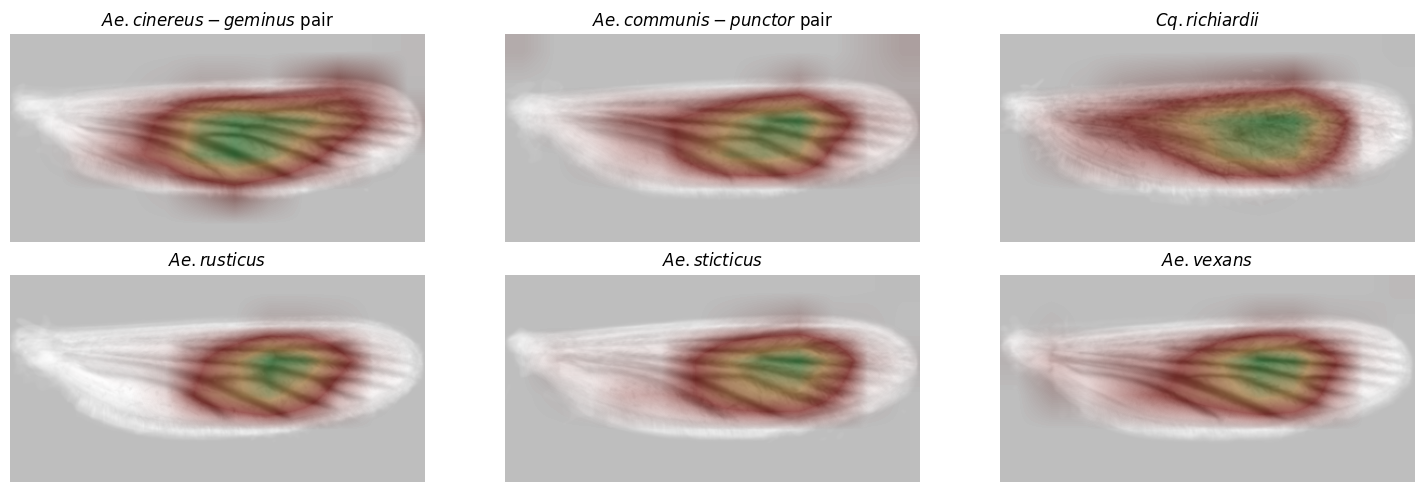

In [ ]:
# Figure 6
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
ax = axes.flatten()

# Create custom species format so species names are italicized
species_format_ls = ['$\\it{Ae. cinereus-geminus\\ }$pair', '$\\it{Ae. communis-punctor\\ }$pair', '$\\it{Cq. richiardii}$',
                     '$\\it{Ae. rusticus}$', '$\\it{Ae. sticticus}$', '$\\it{Ae. vexans}$']

# Create the custom palette
colors = ["white", "#802823", "#A27942", "#326F32"]
custom_palette = sb.blend_palette(colors, as_cmap=True)

for i, key in enumerate(['cinereus-geminus-pair', 'communis-punctor-pair', 'richiardii', 'rusticus', 'sticticus', 'vexans']):
    ax[i].imshow(np.mean(image_dict[key],axis=0), cmap="gray")
    ax[i].imshow(np.mean(grad_dict[key],axis=0), alpha=0.75, cmap=custom_palette)
    ax[i].set_title(key)
    ax[i].axis("off")
    ax[i].set_title(species_format_ls[i], fontsize=12)
plt.tight_layout()
plt.savefig("figures/CAM_example.png", dpi=300)

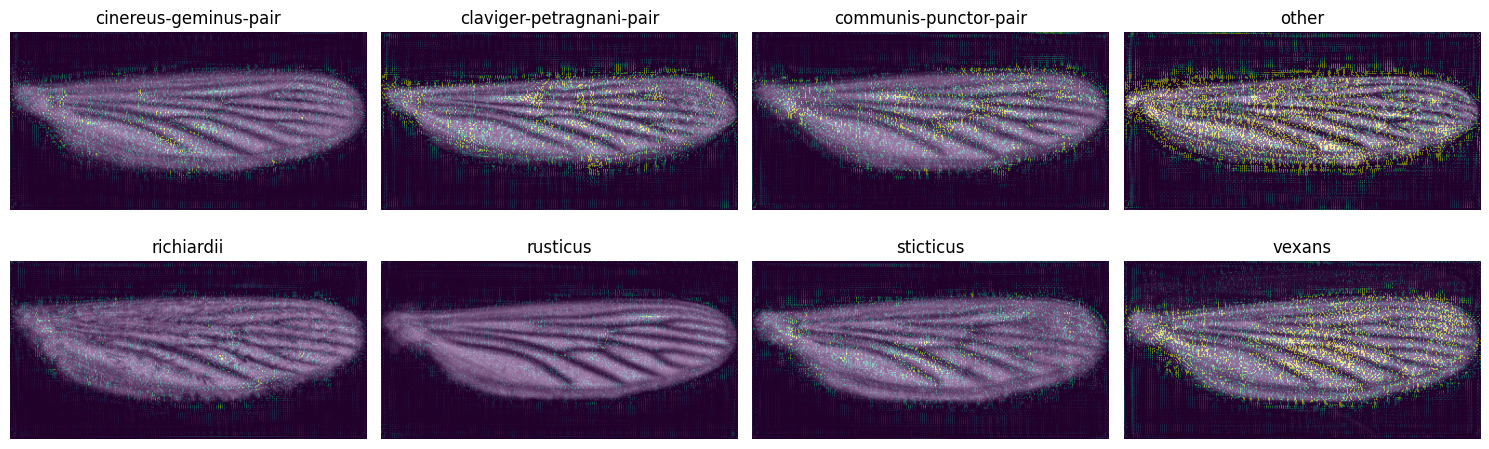

In [ ]:
# Guided GradCam
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
ax = axes.flatten()

for i, key in enumerate(list(grad_dict.keys())[:8]):
    ax[i].imshow(np.mean(image_dict[key],axis=0), cmap="gray")
    ax[i].imshow(np.mean(guided_dict[key],axis=0), alpha=0.5, vmin=0, vmax = .01, cmap="viridis")
    ax[i].set_title(key)
    ax[i].axis("off")

plt.tight_layout()
plt.savefig("figures/guidedCAM_example.png", dpi=300)